Heavily inspired by  https://github.com/usuyama/pytorch-unet

In [1]:
%reset
import torch
import torch.nn as nn
from torchvision import models
from collections import defaultdict
import torch.nn.functional as F
from utils.loss import dice_loss
from utils.dataloader import *
import utils.alienlab as alien

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


## Dataloader

In [2]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

B = 6
labels_names = ['background', 'flowers', 'peduncle', 'stem', 'leaves', 'fruits']

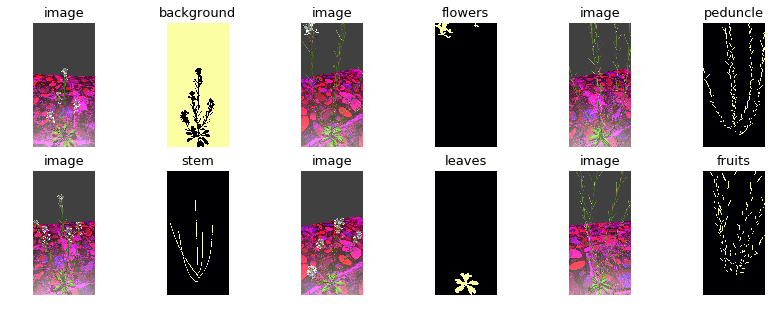

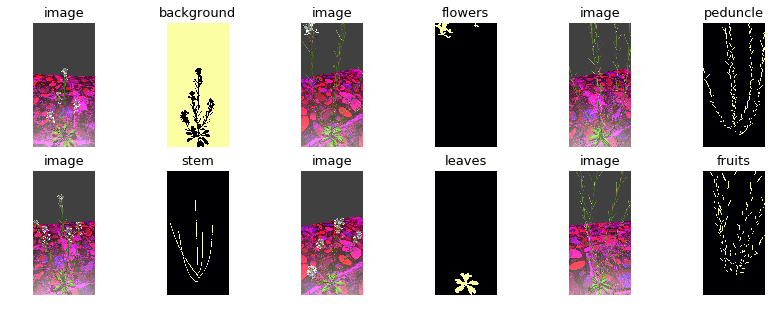

In [3]:


image_paths, target_paths = init_set('train')
#image_paths = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/images/*.png"))
#target_paths = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/labels/*.png"))



trans = transforms.Compose([
    #transforms.Resize((448, 896)),
    transforms.CenterCrop((896, 448)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])


train_dataset = CustomDataset(image_paths, target_paths, transform = trans)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=1)

images, label = next(iter(train_loader))

#plot 4 images to visualize the data
images_tot = []
titles_tot = []
for i in range(B):
    img = images[i]
    img = torchvision.transforms.ToPILImage()(img)
    images_tot.append(img)
    titles_tot.append('image')
    img = label[i,i,:,:].int()
    img = torchvision.transforms.ToPILImage()(img)
    images_tot.append(img)
    titles_tot.append(labels_names[i])

g = alien.showclass()
g.col_num = B
g.figsize = ((14, 5))
g.title_list = titles_tot
g.showing(images_tot)

## Network

In [4]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        # Use ResNet18 as the encoder with the pretrained weights
        self.base_model = models.resnet101(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 256, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(256, 256, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 512, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(512, 512, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 1024, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(1024, 512, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 2048, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(2048, 1024, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up2 = convrelu(512 + 512, 512, 3, 1)
        self.conv_up1 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        #print(x_original.shape)
        x_original = self.conv_original_size1(x_original)
        #print(x_original.shape)
        layer0 = self.layer0(input)
        #print(layer0.shape)
        layer1 = self.layer1(layer0)
        #print(layer1.shape)
        layer2 = self.layer2(layer1)
        #print(layer2.shape)
        layer3 = self.layer3(layer2)
        #print(layer3.shape)
        layer4 = self.layer4(layer3)
        #print(layer4.shape)
        # Upsample the last/bottom layer
        layer4 = self.layer4_1x1(layer4)
        #print(layer4.shape)
        x = self.upsample(layer4)
        #print(x.shape)
        # Create the shortcut from the encoder
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        #print(x.shape)

        x = self.conv_up3(x)
        #print(x.shape)


        x = self.upsample(x)
        #print(x.shape)

        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        #print(x.shape)

        x = self.conv_up2(x)
        #print(x.shape)
        

        x = self.upsample(x)
        #print(x.shape)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        #print(x.shape)
        x = self.conv_up1(x)
        #print(x.shape)

        x = self.upsample(x)
        #print(x.shape)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        #print(x.shape)
        x = self.conv_up0(x)
        #print(x.shape)

        x = self.upsample(x)
        #print(x.shape)
        x = torch.cat([x, x_original], dim=1)
        #print(x.shape)
        x = self.conv_original_size2(x)
        #print(x.shape)

        out = self.conv_last(x)

        return out

## Metrics

In [5]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))
    

def accuracy_compute(mask, prediction):
    mask2 = mask.data.cpu().numpy()
    prediction2= prediction.data.cpu().numpy()
    prediction2 = prediction2 > 0.5
    mask2 = mask2 > 0.5
    accuracy = np.count_nonzero(prediction2 == mask2)
    return accuracy/mask2.size



## Training Function

In [7]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training

In [8]:
image_paths, target_paths = init_set('train')
image_val, target_val = init_set('train')

#image_paths = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/images/*.png"))
#target_paths = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/labels/*.png"))

#image_val = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/images/*.png"))
#target_val = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/labels/*.png"))


batch_size = 4

train_dataset = CustomDataset(image_paths, target_paths, transform=trans)
val_dataset = CustomDataset(image_val, target_val, transform=trans)


image_datasets = {
        'train': train_dataset, 'val': val_dataset 
        }

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    }


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
print(device)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=5)
torch.save(model, 'model_weights/trained_model.pt')


cuda:0
cuda:0
Epoch 0/4
----------
LR 0.0001


/home/alienor/Documents/Segmentation/segmentation/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.064012, dice: 0.321284, loss: 0.192648
val: bce: 0.039477, dice: 0.196005, loss: 0.117741
saving best model
17m 36s
Epoch 1/4
----------
LR 0.0001
train: bce: 0.034262, dice: 0.179580, loss: 0.106921
val: bce: 0.030538, dice: 0.159328, loss: 0.094933
saving best model
17m 23s
Epoch 2/4
----------
LR 0.0001
train: bce: 0.028825, dice: 0.151290, loss: 0.090057
val: bce: 0.030377, dice: 0.143904, loss: 0.087141
saving best model
17m 22s
Epoch 3/4
----------
LR 0.0001
train: bce: 0.026339, dice: 0.135748, loss: 0.081043
val: bce: 0.025744, dice: 0.126463, loss: 0.076104
saving best model
17m 22s
Epoch 4/4
----------
LR 0.0001
train: bce: 0.024802, dice: 0.125203, loss: 0.075003
val: bce: 0.025272, dice: 0.119507, loss: 0.072390
saving best model
17m 21s
Best val loss: 0.072390


/home/alienor/Documents/Segmentation/segmentation/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNetUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


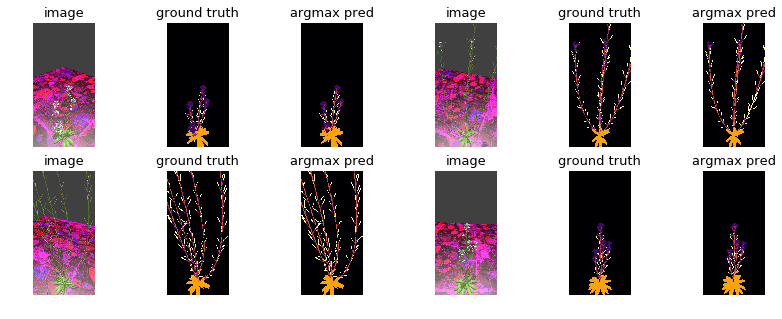

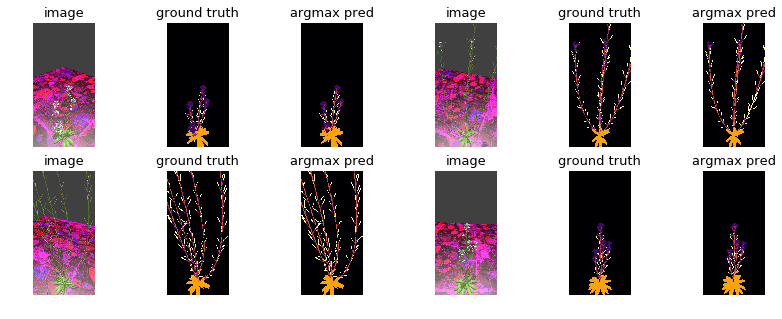

In [9]:
import math

model.eval()   # Set model to the evaluation mode

# Create another simulation dataset for test
image_test, target_test = init_set('train')
#image_test = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/images/*.png"))
#target_test = np.sort(glob.glob("segmentation_arabidopsis/arabidopsis999/labels/*.png"))




test_dataset = CustomDataset(image_test[0:72], target_test[0:72], transform = trans)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)



# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()

# Change channel-order and make 3 channels for matplot
input_images_cpu = [reverse_transform(x) for x in inputs.cpu()]
labels_cpu = labels.cpu().numpy()

# Map each channel (i.e. class) to each color
compare = []
lab = 4
tl = []
for i in range(len(pred)):
    compare.append(input_images_cpu[i])
    tl.append('image')
    compare.append(np.argmax(labels_cpu[i], axis = 0))
    tl.append('ground truth')
    #compare.append(pred[i][lab])
    #tl.append('class pred')
    compare.append(np.argmax(pred[i], axis = 0))
    tl.append('argmax pred')
g.title_list = tl
g.showing(compare)

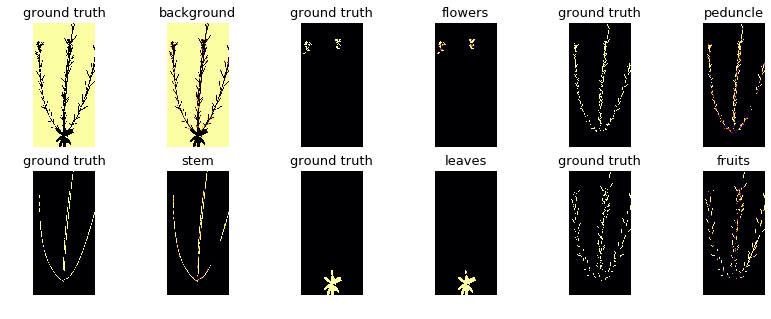

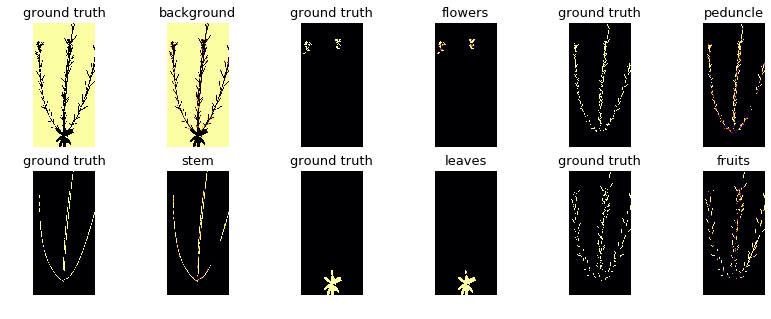

In [10]:
compare = []
lab = 4
tl = []
for i in range(6):
    compare.append(labels_cpu[1][i])
    tl.append('ground truth')
    compare.append(pred[1][i])
    tl.append(labels_names[i])

g.title_list = tl
g.showing(compare)

In [ ]:
pred.shape